In [5]:
import numpy as np
import numpy.matlib as nm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, model, h = -1):
        if theta.shape[0]>1:
            sq_dist = pdist(theta)
            pairwise_dists = squareform(sq_dist)**2
            if h < 0: # if h < 0, using median trick
                h = np.median(pairwise_dists)  
                h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

            # compute the rbf kernel
            w_s = model.cal_w_s(theta)
            Kxy = np.exp( -pairwise_dists / h**2 / 2) 
            wxK = nm.repmat(w_s[np.newaxis,:], Kxy.shape[0], 1)   #  every xj's weights 
#             print('wxK:',wxK)
            Kxy = np.multiply(Kxy, wxK)     # weighted kernel
            dxkxy = -np.matmul(Kxy, theta)
            sumkxy = np.sum(Kxy, axis=1)
            for i in range(theta.shape[1]):
                dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
            dxkxy = dxkxy / (h**2)
            
        else:
            Kxy = np.ones((1,1))
            dxkxy = np.zeros(theta.shape)
        return (Kxy, dxkxy)
    
 
    def update(self, model, x0, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or model.dlnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))
            # lamda = 1 - iter/(2*n_iter)
            # model.anneal(lamda)
            show1(theta, model, iter)
#             print('theta:',theta)
            lnpgrad = model.dlnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, model, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
        return theta
 
def show1(x0, model, iter):
#     theta = model.sigmoid(theta)[0]
    if x0.shape[1] == 1 and iter % 50 == 0:
        f, ax = plt.subplots(figsize=(6, 6))
        sns.set(style="white", palette="muted", color_codes=True)
        plt.plot(model.targetx[0],model.targety[0],linewidth=5,color='r',label='Target')
        # plt.fill_between(model.targetx[0], model.targety[0], interpolate=True, color='red', alpha=0.2)
        for i in range(len(model.targetx)-1):
            plt.plot(model.targetx[i+1],model.targety[i+1],linewidth=5,color='r')
            # plt.fill_between(model.targetx[i+1], model.targety[i+1], interpolate=True, color='red', alpha=0.2)
        plt.scatter(x0.squeeze(),0.02+np.zeros(x0.squeeze().shape),color='g',s=100,label='Particles')
        # sns.kdeplot(model.surrogate(), color='b', bw=.15, shade=True,label='Surrogate')
        # sns.kdeplot(x0.squeeze(), color='g', bw=.1, shade=True,label="Particles' Density")

        ##### only binary
        # plt.plot(model.targetx[0][0:750],model.y[0:750],linewidth=5,color='g',label='Approximated Density')
        # plt.plot(model.targetx[1][0:250],model.y[0:250],linewidth=5,color='g')

        # plt.plot(model.targetx[0][0:500],model.y[0:500],linewidth=5,color='g',label='Approximated Density')
        # plt.plot(model.targetx[1][0:500],model.y[0:500],linewidth=5,color='g')

        # plt.plot(model.targetx[0][0:380],model.y[0:380],linewidth=5,color='g',label='Approximated Density')
        # plt.plot(model.targetx[1][0:620],model.y[0:620],linewidth=5,color='g')
        ###############

        plt.plot(model.x, model.partition, 'r--', linewidth=1, label='Transformed Target')
        plt.fill_between(model.x, model.partition, interpolate=True, color = 'r', alpha=0.2)
        plt.plot(model.x, model.surrogate, linewidth=1, color = 'b', label='Surrogate')
        plt.fill_between(model.x, model.surrogate, interpolate=True, color='b', alpha=0.2)
        plt.legend(loc=2, fontsize=16)
        plt.xlim([-4,4])
        plt.ylim([0,1])
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.title(str(iter)+'th iteration',fontsize=30)
        plt.savefig('./fig/binaryIter='+str(iter)+'.pdf',format='pdf')
        plt.show()


def show2(theta, model, DataGuassian, iter):
#     theta = model.sigmoid(theta)[0]
    if theta.shape[1]==2 and theta.shape[0]>=100 and iter % 50 == 0:
        f, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect("equal")
        sns.kdeplot(DataGuassian.X, DataGuassian.Y, bw="silverman",cmap='BuGn_d')
        sns.kdeplot(model.DataBinomial.X, model.DataBinomial.Y, bw="silverman",cmap='Reds')
        plt.scatter(theta[:,0],theta[:,1],s=10,c='b')
        # plt.title('GF-SVGD smaples at iter'+str(iter))
        plt.savefig('./fig/Samples='+str(theta.shape[0])+'Iter='+str(iter)+'.pdf',format='pdf')
        plt.show()
    
    
    
    
    

In [6]:
import numpy as np
import numpy.matlib as nm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from numpy.linalg import inv
import scipy.io as scio

class MVN:
    def __init__(self, mu, scale, pTrue, domain):
        self.mu = mu
        self.scale = scale
        self.A = 1/np.square(scale)
        self.pTrue = pTrue
        self.domain = domain
        self.targetx = [domain[i]*np.ones(1000) for i in range(len(domain))]
        self.targety = [np.linspace(0,pTrue[i],1000) for i in range(len(domain))]
        self.y = np.linspace(0,1,1000)
        self.x1 = np.linspace(-5,0,100)
        self.x2 = np.linspace(0,5,100)
        self.x = np.hstack((self.x1,self.x2))
        self.surrogate = (1/(np.sqrt(2*np.pi)*scale))*np.exp(-(self.x**2+(self.x-mu)**2)*self.A/2)
        self.partition = np.hstack((pTrue[0]* np.exp(-(self.x1**2)/2), pTrue[1]*np.exp(-(self.x2**2)/2)))
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), np.diag(self.A))-theta
    
    def cal_w_s(self, x0):
        w_s = np.ones(x0.shape[0])
        for i in range(x0.shape[0]):
            phat = np.exp(np.matmul(np.matmul(x0[i,:]-self.mu, np.diag(self.A)), x0[i,:]-self.mu))
            p    = np.exp(np.matmul(np.matmul(np.sign(x0[i,:])-self.mu, np.diag(self.A)), np.sign(x0[i,:])-self.mu))
            w_s[i] = 1.0*phat/p

        w_s = (w_s/np.sum(w_s)).squeeze()
        return w_s

pTrue: [ 0.37754067  0.62245933]
muTrue 0.244918662404
n= 20


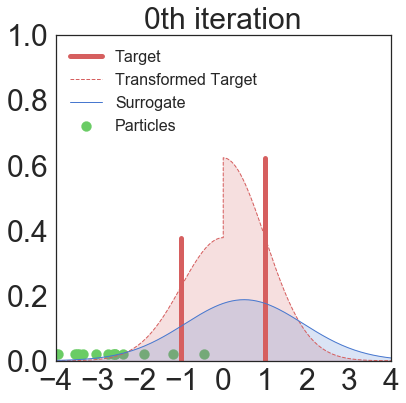

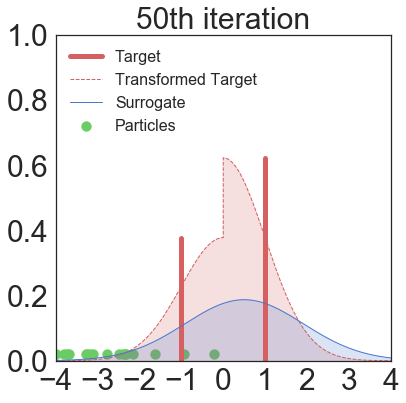

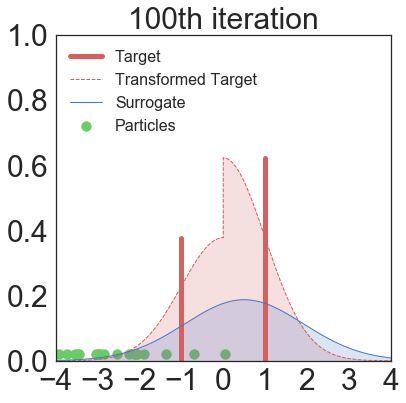

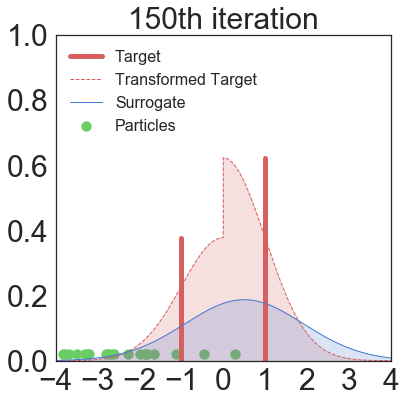

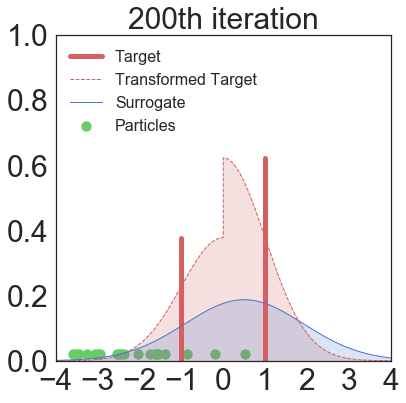

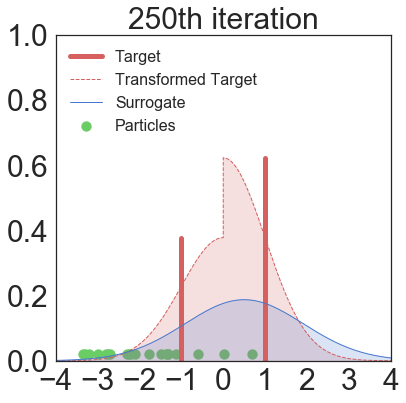

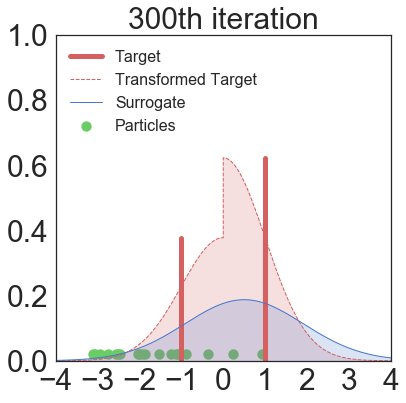

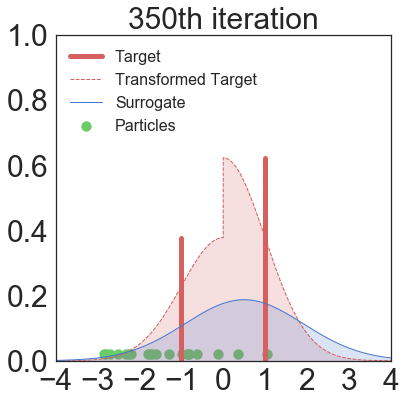

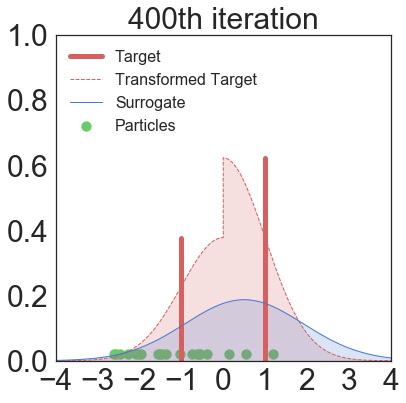

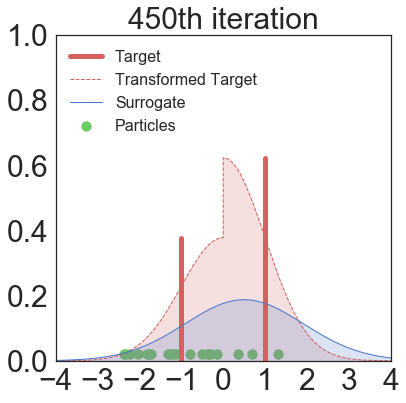

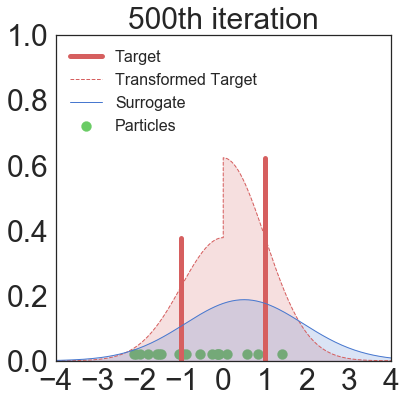

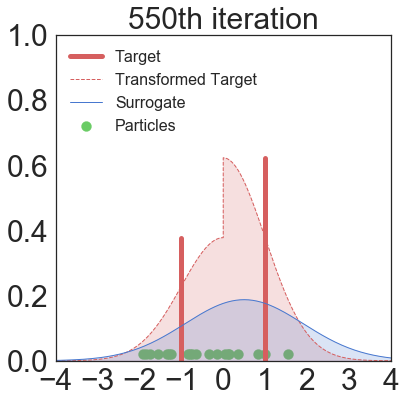

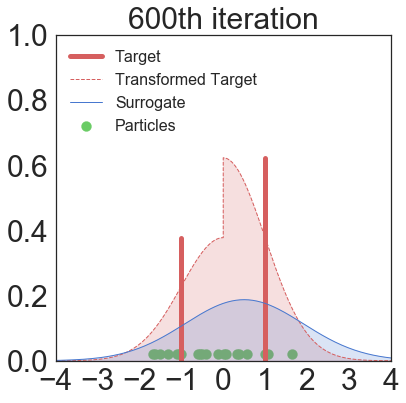

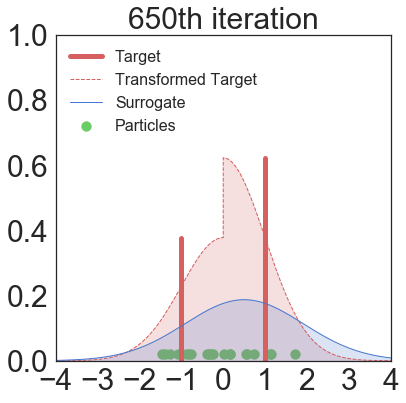

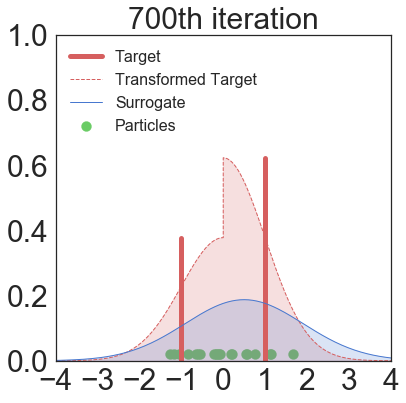

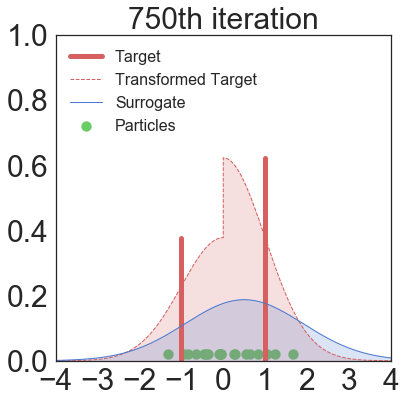

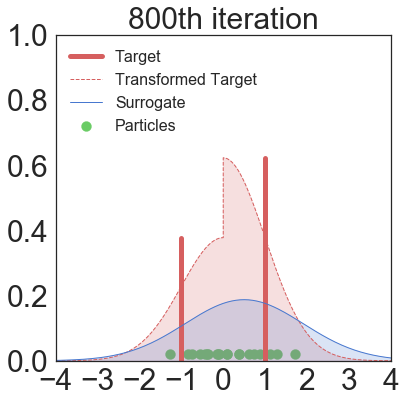

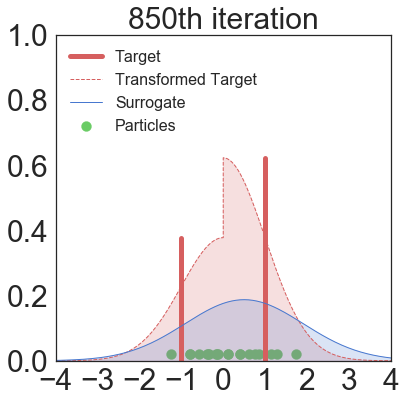

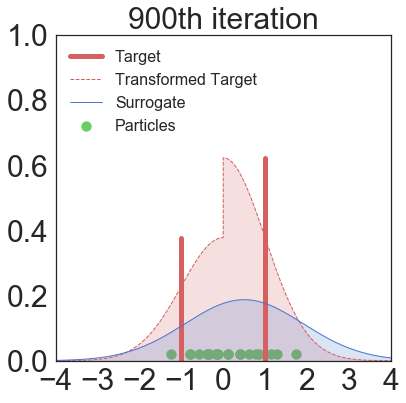

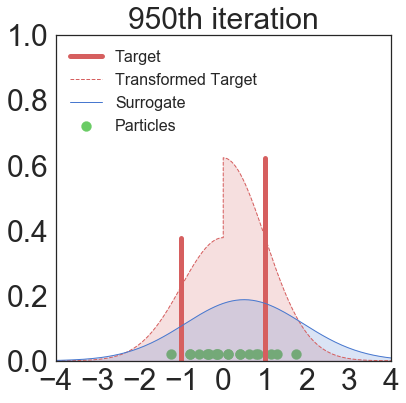

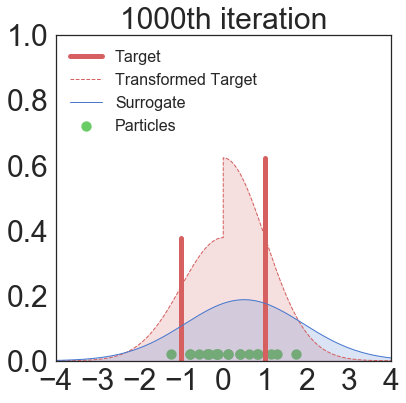

GF-SVGD 0.014621249414
Monte-Carlo 0


In [9]:
if __name__ == '__main__':
    dim = 1
    n = 20
    mu = 1
    scale = np.ones(dim)*2
    domain = np.array([-1,1])
    pTrue = st.norm.pdf(domain,mu,scale)
    pTrue = pTrue/np.sum(pTrue)
    muTrue = np.matmul(domain,pTrue)

    model = MVN(mu, scale, pTrue, domain)
    print('pTrue:',pTrue)
    print('muTrue',muTrue)

    print('n=',n)
    theta1 = 0
    x0 = np.random.normal(-3,1,[n,dim])
    theta = SVGD().update(model, x0, n_iter=1050, stepsize=0.005)
    theta1 += np.mean((np.mean(theta,0)-muTrue)**2) 


    theta2 = 0
#     for j in range(1000):
#         for k in range(dim):
#             theta = np.random.binomial(1, model.pTrue[k], n)
#             theta[np.where(theta==0)]=-1
#             theta2 += ((np.mean(theta)-model.muTrue[k])**2)/(1000*dim)

    print('GF-SVGD',theta1)
    print('Monte-Carlo',theta2)